# 注意力机制

平均汇聚层可以被视为输入的加权平均值，其中各输入的权重是一样的。实际上，注意力汇聚得到的是加权平均的总和值，其中权重是在给定的查询和不同的键之间计算得出的。

In [28]:
import torch
from torch import nn
from d2l import torch as d2l
import math

为了可视化注意力权重，需要定义一个show_heatmaps函数。 其输入matrices的形状是 （要显示的行数，要显示的列数，查询的数目，键的数目）。

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

下面使用一个简单的例子进行演示。 在本例子中，仅当查询和键相同时，注意力权重为1，否则为0。

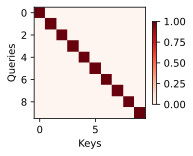

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# 注意力汇聚：Nadaraya-Watson 核回归

## [**生成数据集**]

简单起见，考虑下面这个回归问题：
给定的成对的“输入－输出”数据集
$\{(x_1, y_1), \ldots, (x_n, y_n)\}$，
如何学习$f$来预测任意新输入$x$的输出$\hat{y} = f(x)$？

根据下面的非线性函数生成一个人工数据集，
其中加入的噪声项为$\epsilon$：

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

其中$\epsilon$服从均值为$0$和标准差为$0.5$的正态分布。
在这里生成了$50$个训练样本和$50$个测试样本。
为了更好地可视化之后的注意力模式，需要将训练样本进行排序。

In [5]:
n_train = 50  # 训练样本数
# 生成一个包含50个随机数的张量，这些随机数位于0到1之间。
# * 5：将这些随机数乘以5，将它们的范围扩展到0到5之间
# torch.sort()返回两个张量，一个包含已排序的值(x_train)，另一个包含排序后的索引，但在这里我们不需要索引，所以用下划线(_)表示忽略
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

下面的函数将绘制所有的训练样本（样本由圆圈表示），
不带噪声项的真实数据生成函数$f$（标记为“Truth”），
以及学习得到的预测函数（标记为“Pred”）。


In [6]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## 平均汇聚

先使用最简单的估计器来解决回归问题。
基于平均汇聚来计算所有训练样本输出值的平均值：

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$


如下图所示，这个估计器确实不够聪明。
真实函数$f$（“Truth”）和预测函数（“Pred”）相差很大。


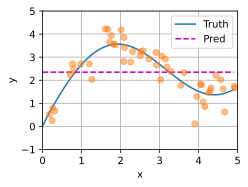

In [7]:
# torch.repeat_interleave(..., n_test)：这部分将均值复制了n_test次，生成了一个长度为n_test的张量y_hat，其中每个元素都是训练样本输出的均值。
# 这是在模拟一种基于训练数据的简单预测方法，其中测试样本的所有预测值都是训练数据输出的均值。
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

##  非参数注意力汇聚 

显然，平均汇聚忽略了输入$x_i$。
于是提出了一个更好的想法，
根据输入的位置对输出$y_i$进行加权：

$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$


其中$K$是*核*（kernel）。
所描述的估计器被称为
*Nadaraya-Watson核回归*（Nadaraya-Watson kernel regression）。
这里不会深入讨论核函数的细节，
但受此启发，
我们可以从注意力机制框架的角度
重写以上公式，
成为一个更加通用的*注意力汇聚*（attention pooling）公式：

$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$

其中$x$是查询，$(x_i, y_i)$是键值对。
注意力汇聚是$y_i$的加权平均。
将查询$x$和键$x_i$之间的关系建模为
*注意力权重*（attention weight）$\alpha(x, x_i)$，
这个权重将被分配给每一个对应值$y_i$。
对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：
它们是非负的，并且总和为1。

为了更好地理解注意力汇聚，
下面考虑一个*高斯核*（Gaussian kernel），其定义为：

$$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$$

将高斯核代入可以得到：

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$


如果一个键$x_i$越是接近给定的查询$x$，
那么分配给这个键对应值$y_i$的注意力权重就会越大，
也就“获得了更多的注意力”。

值得注意的是，Nadaraya-Watson核回归是一个非参数模型。
因此，是
*非参数的注意力汇聚*（nonparametric attention pooling）模型。
接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。
从绘制的结果会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。


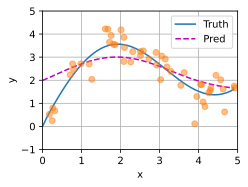

In [10]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
# x_test.repeat_interleave(n_train) x_test是测试样本的输入，通过.repeat_interleave(n_train)操作，它将被重复n_train次，以便每行包含相同的测试输入，就像每个查询都有相同的输入
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重 dim=1指定 softmax 在每行上进行操作，确保每行的权重之和为1
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

现在来观察注意力的权重。
这里测试数据的输入相当于查询，而训练数据的输入相当于键。
因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近，
注意力汇聚的[**注意力权重**]就越高。


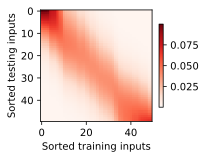

In [16]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## [**带参数注意力汇聚**]

非参数的Nadaraya-Watson核回归具有*一致性*（consistency）的优点：
如果有足够的数据，此模型会收敛到最优结果。
尽管如此，我们还是可以轻松地将可学习的参数集成到注意力汇聚中。

例如，在下面的查询$x$和键$x_i$之间的距离乘以可学习参数$w$：

$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$


本节的余下部分将通过训练这个模型来学习注意力汇聚的参数。

### 批量矩阵乘法

为了更有效地计算小批量数据的注意力，
我们可以利用深度学习开发框架中提供的批量矩阵乘法。

假设第一个小批量数据包含$n$个矩阵$\mathbf{X}_1,\ldots, \mathbf{X}_n$，
形状为$a\times b$，
第二个小批量包含$n$个矩阵$\mathbf{Y}_1, \ldots, \mathbf{Y}_n$，
形状为$b\times c$。
它们的批量矩阵乘法得到$n$个矩阵
$\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$，
形状为$a\times c$。
因此，[**假定两个张量的形状分别是$(n,a,b)$和$(n,b,c)$，
它们的批量矩阵乘法输出的形状为$(n,a,c)$**]。


In [17]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [18]:
X, Y, torch.bmm(X, Y)

(tensor([[[1., 1., 1., 1.]],
 
         [[1., 1., 1., 1.]]]),
 tensor([[[1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.]],
 
         [[1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.]]]),
 tensor([[[4., 4., 4., 4., 4., 4.]],
 
         [[4., 4., 4., 4., 4., 4.]]]))

在注意力机制的背景中，我们可以[**使用小批量矩阵乘法来计算小批量数据中的加权平均值**]。


In [19]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [20]:
weights,values,weights.unsqueeze(1),values.unsqueeze(-1),torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

(tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000]]),
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]]),
 tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
           0.1000, 0.1000]],
 
         [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
           0.1000, 0.1000]]]),
 tensor([[[ 0.],
          [ 1.],
          [ 2.],
          [ 3.],
          [ 4.],
          [ 5.],
          [ 6.],
          [ 7.],
          [ 8.],
          [ 9.]],
 
         [[10.],
          [11.],
          [12.],
          [13.],
          [14.],
          [15.],
          [16.],
          [17.],
          [18.],
          [19.]]]),
 tensor([[[ 4.5000]],
 
         [[14.5000]]]))

### 定义模型

基于[**带参数的注意力汇聚**]，使用小批量矩阵乘法，定义Nadaraya-Watson核回归的带参数版本为：

In [21]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # w是标量
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

### 训练

接下来，[**将训练数据集变换为键和值**]用于训练注意力模型。
在带参数的注意力汇聚模型中，
任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算，
从而得到其对应的预测输出。


In [23]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

[**训练带参数的注意力汇聚模型**]时，使用平方损失函数和随机梯度下降。

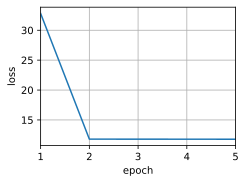

In [24]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

如下所示，训练完带参数的注意力汇聚模型后可以发现：
在尝试拟合带噪声的训练数据时，
[**预测结果绘制**]的线不如之前非参数模型的平滑。


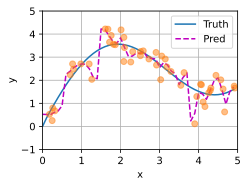

In [25]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

为什么新的模型更不平滑了呢？
下面看一下输出结果的绘制图：
与非参数的注意力汇聚模型相比，
带参数的模型加入可学习的参数后，
[**曲线在注意力权重较大的区域变得更不平滑**]。


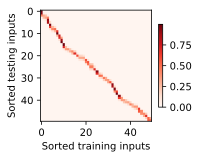

In [27]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

* Nadaraya-Watson核回归是具有注意力机制的机器学习范例。
* Nadaraya-Watson核回归的注意力汇聚是对训练数据中输出的加权平均。从注意力的角度来看，分配给每个值的注意力权重取决于将值所对应的键和查询作为输入的函数。
* 注意力汇聚可以分为非参数型和带参数型。

# 注意力评分函数
高斯核指数部分可以视为注意力评分函数（attention scoring function）， 简称评分函数（scoring function）， 然后把这个函数的输出结果输入到softmax函数中进行运算。 通过上述步骤，将得到与键对应的值的概率分布（即注意力权重）。 最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。
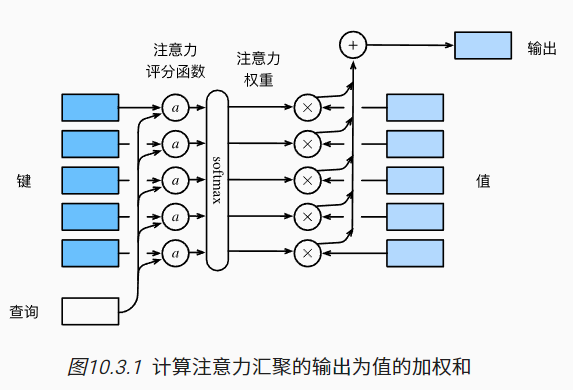
用数学语言描述，假设有一个查询
$\mathbf{q} \in \mathbb{R}^q$和
$m$个“键－值”对
$(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，
其中$\mathbf{k}_i \in \mathbb{R}^k$，$\mathbf{v}_i \in \mathbb{R}^v$。
注意力汇聚函数$f$就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$

其中查询$\mathbf{q}$和键$\mathbf{k}_i$的注意力权重（标量）
是通过注意力评分函数$a$将两个向量映射成标量，
再经过softmax运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$

正如上图所示，选择不同的注意力评分函数$a$会导致不同的注意力汇聚操作。
本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。

## [**掩蔽softmax操作**]

正如上面提到的，softmax操作用于输出一个概率分布作为注意力权重。
在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。
例如，为了在高效处理小批量数据集，某些文本序列被填充了没有意义的特殊词元。为了仅将有意义的词元作为值来获取注意力汇聚，可以指定一个有效序列长度（即词元的个数），
以便在计算softmax时过滤掉超出指定范围的位置。
下面的`masked_softmax`函数实现了这样的*掩蔽softmax操作*（masked softmax operation），其中任何超出有效长度的位置都被掩蔽并置为0。


In [30]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

为了[**演示此函数是如何工作**]的，
考虑由两个$2 \times 4$矩阵表示的样本，
这两个样本的有效长度分别为$2$和$3$。
经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。

In [31]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.6361, 0.3639, 0.0000, 0.0000],
         [0.3681, 0.6319, 0.0000, 0.0000]],

        [[0.3405, 0.2502, 0.4093, 0.0000],
         [0.4847, 0.2552, 0.2601, 0.0000]]])

同样，也可以使用二维张量，为矩阵样本中的每一行指定有效长度。

In [32]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3753, 0.2486, 0.3761, 0.0000]],

        [[0.2855, 0.7145, 0.0000, 0.0000],
         [0.1758, 0.2761, 0.2014, 0.3467]]])

## [**加性注意力**]

一般来说，当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。
给定查询$\mathbf{q} \in \mathbb{R}^q$和
键$\mathbf{k} \in \mathbb{R}^k$，
*加性注意力*（additive attention）的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$


其中可学习的参数是$\mathbf W_q\in\mathbb R^{h\times q}$、
$\mathbf W_k\in\mathbb R^{h\times k}$和
$\mathbf w_v\in\mathbb R^{h}$。

将查询和键连结起来后输入到一个多层感知机（MLP）中，
感知机包含一个隐藏层，其隐藏单元数是一个超参数$h$。
通过使用$\tanh$作为激活函数，并且禁用偏置项。

下面来实现加性注意力。

In [33]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        # 我认为 每一行查询的（1，num_hidden) 按行复制  复制“键－值”对的个数 复制（“键－值”对的个数，num_hiddens) 查询的个数次
        # 也许相当于每个查询 都对应一个“键－值”表，
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # features(batch_size，查询的个数，“键－值”对的个数，num_hiddens)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

用一个小例子来[**演示上面的`AdditiveAttention`类**]，
其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小），
实际输出为$(2,1,20)$、$(2,10,2)$和$(2,10,4)$。
注意力汇聚输出的形状为（批量大小，查询的步数，值的维度）。


In [49]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的，
所以[**注意力权重**]是均匀的，由指定的有效长度决定。


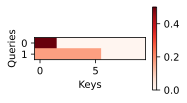

In [53]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')


## [**缩放点积注意力**]

使用点积可以得到计算效率更高的评分函数，
但是点积操作要求查询和键具有相同的长度$d$。
假设查询和键的所有元素都是独立的随机变量，
并且都满足零均值和单位方差，
那么两个向量的点积的均值为$0$，方差为$d$。
为确保无论向量长度如何，
点积的方差在不考虑向量长度的情况下仍然是$1$，
我们再将点积除以$\sqrt{d}$，
则*缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

在实践中，我们通常从小批量的角度来考虑提高效率，
例如基于$n$个查询和$m$个键－值对计算注意力，
其中查询和键的长度为$d$，值的长度为$v$。
查询$\mathbf Q\in\mathbb R^{n\times d}$、
键$\mathbf K\in\mathbb R^{m\times d}$和
值$\mathbf V\in\mathbb R^{m\times v}$的缩放点积注意力是：

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$


下面的缩放点积注意力的实现使用了暂退法进行模型正则化。


In [54]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

为了[**演示上述的`DotProductAttention`类**]，
我们使用与先前加性注意力例子中相同的键、值和有效长度。
对于点积操作，我们令查询的特征维度与键的特征维度大小相同。


In [55]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

与加性注意力演示相同，由于键包含的是相同的元素，
而这些元素无法通过任何查询进行区分，因此获得了[**均匀的注意力权重**]。


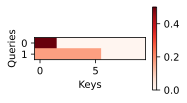

In [56]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

* 将注意力汇聚的输出计算可以作为值的加权平均，选择不同的注意力评分函数会带来不同的注意力汇聚操作。
* 当查询和键是不同长度的矢量时，可以使用可加性注意力评分函数。当它们的长度相同时，使用缩放的“点－积”注意力评分函数的计算效率更高。

#  Bahdanau 注意力

## 模型
下面描述的Bahdanau注意力模型
这个新的基于注意力的模型中的上下文变量$\mathbf{c}$
在任何解码时间步$t'$都会被$\mathbf{c}_{t'}$替换。
假设输入序列中有$T$个词元，
解码时间步$t'$的上下文变量是注意力集中的输出：

$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t,$$

其中，时间步$t' - 1$时的解码器隐状态$\mathbf{s}_{t' - 1}$是查询，
编码器隐状态$\mathbf{h}_t$既是键，也是值，
注意力权重$\alpha$是使用加性注意力打分函数计算的。

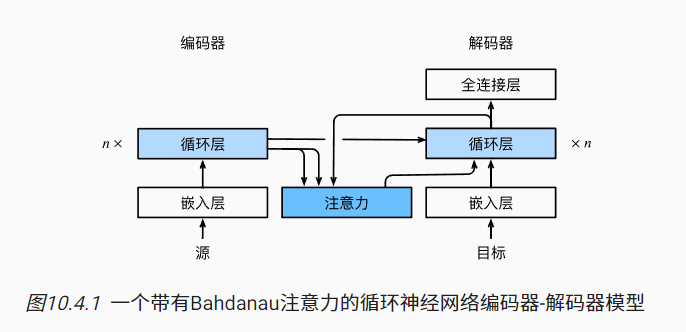

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 定义注意力解码器

下面看看如何定义Bahdanau注意力，实现循环神经网络编码器-解码器。
其实，我们只需重新定义解码器即可。
为了更方便地显示学习的注意力权重，
以下`AttentionDecoder`类定义了[**带有注意力机制解码器的基本接口**]。

In [2]:
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

接下来，让我们在接下来的`Seq2SeqAttentionDecoder`类中
[**实现带有Bahdanau注意力的循环神经网络解码器**]。
首先，初始化解码器的状态，需要下面的输入：

1. 编码器在所有时间步的最终层隐状态，将作为注意力的键和值；
1. 上一时间步的编码器全层隐状态，将作为初始化解码器的隐状态；
1. 编码器有效长度（排除在注意力池中填充词元）。

在每个解码时间步骤中，解码器上一个时间步的最终层隐状态将用作查询。
因此，注意力输出和输入嵌入都连结为循环神经网络解码器的输入。

In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            # hidden_state[-1] 上一层RNN输出的最后一层
            # 相当于加一层number of query
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            # 增加的1 是key的维度
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结 context多一维 x也要升维
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

接下来，使用包含7个时间步的4个序列输入的小批量[**测试Bahdanau注意力解码器**]。

In [14]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## [**训练**]
在这里指定超参数，实例化一个带有Bahdanau注意力的编码器和解码器，
并对这个模型进行机器翻译训练。
由于新增的注意力机制，训练要比没有注意力机制的慢得多。

loss 0.021, 8465.1 tokens/sec on cuda:0


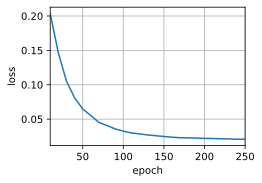

In [5]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

模型训练后，我们用它[**将几个英语句子翻译成法语**]并计算它们的BLEU分数。

In [6]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est gagné .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [7]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))
# 这一行代码将所有时间步的注意力权重张量按照第一个维度（通常是 batch_size 维度）进行拼接，即将它们堆叠在一起。这将生成一个新的张量，其形状为 (batch_size * num_steps, 1, num_steps)。
# reshape((1, 1, -1, num_steps)) 用于重新形状合并后的张量。在这里，-1 表示自动计算该维度的大小，以确保其他维度的大小保持不变。这将生成一个新的张量，其形状为 (1, 1, batch_size * num_steps, num_steps)。

训练结束后，下面通过[**可视化注意力权重**]
会发现，每个查询都会在键值对上分配不同的权重，这说明
在每个解码步中，输入序列的不同部分被选择性地聚集在注意力池中。


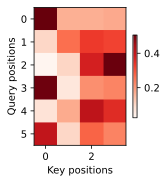

In [8]:
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

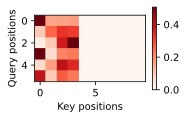

In [9]:
d2l.show_heatmaps(
    attention_weights.cpu(),
    xlabel='Key positions', ylabel='Query positions')

* 在预测词元时，如果不是所有输入词元都是相关的，那么具有Bahdanau注意力的循环神经网络编码器-解码器会有选择地统计输入序列的不同部分。这是通过将上下文变量视为加性注意力池化的输出来实现的。
* 在循环神经网络编码器-解码器中，Bahdanau注意力将上一时间步的解码器隐状态视为查询，在所有时间步的编码器隐状态同时视为键和值。